# Trabajo práctico n° 2
## Evolución del salario joven

Integrantes:
- Mazo, Luis
- Hoj, Agustín
- Nacucchio, Illed

El objetivo de este programa es analizar la evolución del salario joven desde el 2007 hasta la actualidad y predecir cómo seguirá evolucionando el año entrante. Además, se propone hacer comparaciones con el salario mínimo correspondiente a la época para hacer deducciones sobre la valoración de cada sector de trabajo. Para ello contamos con tres datasets: uno que contiene los datos sobre el salario en distintos sectores desde el 2007 hasta junio del 2023, otro que contiene los valores de conversión a dólar del peso argentino desde el 2003 a la actualidad, y uno sobre el salario mínimo. Además, contamos con un dataset de apoyo del que extraeremos un diccionario con la información de los sectores de trabajo que se tienen en cuenta.

### Librerías

In [1741]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')

### Preparación de los dataframes

In [1742]:
def salarios():   
     # Primero preparamos el dataframe donde quedará almacenado el dataset sobre salario joven, ofrecido por fuentes gubernamentales.
    dfSalarios = pd.read_csv("salario_joven.csv")
    dfSalarios.rename(columns={
        'fecha': 'Fecha',
        'clae2': 'Sector',
        'w_median': 'Sueldo Promedio'},
        inplace=True
    )

    # Previsualización del dataframe
    dfSalarios.head()
    return(dfSalarios)
dfSalarios = salarios()

In [1743]:
# Generamos un diccionario con la información correspondiente a cada sector de trabajo incluido en el dataset
# Primero cargamos el dataset en un DataFrame
dfSectores = pd.read_csv('clae_agg.csv')

# Creamos un diccionario a partir de las columnas clae2 y clae2_desc, que se corresponden al ID del sector y su nombre
sectores_descripcion = dict(zip(dfSectores['clae2'], dfSectores['clae2_desc']))

# Imprimimos el diccionario resultante
print("Referencias de cada sector: ")
for clave, valor in sectores_descripcion.items():
    print(f"{clave}: {valor}")

Referencias de cada sector: 
1: Agricultura, ganadería, caza y servicios relacionados
2: Silvicultura y explotación forestal
3: Pesca y acuicultura
5: Extracción de carbón y lignito
6: Extracción de petróleo crudo y gas natural
7: Extracción de minerales metálicos
8: Extracción de otros minerales
9: Actividades de apoyo al petróleo y la minería
10: Elaboración de productos alimenticios
11: Elaboración de bebidas
12: Elaboración de productos de tabaco
13: Elaboración de productos textiles
14: Elaboración de prendas de vestir
15: Elaboración de productos de cuero y calzado
16: Elaboración de productos de madera
17: Elaboración de productos de papel
18: Imprentas y editoriales
19: Fabricación de productos de refinación de petróleo
20: Fabricación de sustancias químicas
21: Elaboracion de productos farmacéuticos
22: Fabricación de productos de caucho y plástico
23: Fabricación de productos de vidrio y otros minerales no metálicos
24: Fabricación de metales comunes
25: Fabricación de produc

In [1744]:
# Construimos una función para generar un promedio por mes de cada año de la conversión del dólar oficial y dólar blue
def calcular_tasa_promedio_mensual(csv_file, _encoding):
    # Columnas que deseamos leer (en este caso, las dos primeras); son las que necesitamos y las demás generan conflictos en su lectura
    columns_to_read = ['Fecha', 'Último']

    # Cargamos el CSV utilizando solo las columnas especificadas
    dfDolar = pd.read_csv(csv_file, sep=',', encoding=_encoding, usecols=columns_to_read)

    # Convertimos la 'Fecha' a tipo datetime
    dfDolar['Fecha'] = pd.to_datetime(dfDolar['Fecha'], dayfirst=True)
        
    # Convertimos 'Último' a tipo numérico, ignorando los errores
    dfDolar['Último'] = pd.to_numeric(dfDolar['Último'], errors='coerce')
        
    # Por si acaso, eliminamos filas con valores no numéricos
    dfDolar = dfDolar.dropna(subset=['Último'])
        
    # Creamos columnas adicionales para año y mes
    dfDolar['Año'] = dfDolar['Fecha'].dt.year
    dfDolar['Mes'] = dfDolar['Fecha'].dt.month

    # Modificamos el nombre de la columna 'Último'
    dfDolar = dfDolar.rename(columns={'Último': 'Conversión promedio'})

    # Calculamos el promedio mensual de conversión
    promedio_mensual = dfDolar.groupby(['Año', 'Mes'])['Conversión promedio'].mean().reset_index()
    
    return promedio_mensual # Lo devolvemos

In [1745]:
# Dólar oficial
promedioOficial = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')
promedioOficial

,Año,Mes,Conversión promedio
0,2007,1,0.324170
1,2007,2,0.322330
2,2007,3,0.322491
3,2007,4,0.323576
4,2007,5,0.324687
...,...,...,...
198,2023,7,0.003754
199,2023,8,0.003129
200,2023,9,0.002860
201,2023,10,0.002860


In [1746]:
# Dólar blue
promedioBlue = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')
promedioBlue

,Año,Mes,Conversión promedio
0,2007,1,3.104783
1,2007,2,3.115500
2,2007,3,3.119091
3,2007,4,3.117619
4,2007,5,3.113478
...,...,...,...
198,2023,7,517.710526
199,2023,8,669.318182
200,2023,9,735.750000
201,2023,10,907.875000


In [1747]:
def salario_a_dolar_oficial(_df, _tipoDolar):

    _df['Fecha'] = pd.to_datetime(_df['Fecha'], dayfirst=True)

    # Crear columnas adicionales para año y mes en dfSalarios
    _df['Año'] = _df['Fecha'].dt.year
    _df['Mes'] = _df['Fecha'].dt.month

    # Unir dfSalarios con el promedio_mensual del dólar
    _df = pd.merge(_df, _tipoDolar, on=['Año', 'Mes'], how='left')

    # Calcular el equivalente del salario en dólares
    _df['Salario en dólar oficial'] = _df['Sueldo Promedio'] * _df['Conversión promedio']

    # Eliminamos la columna 'Fecha' y 'Conversión promedio'
    _df = _df.drop('Fecha', axis=1)
    _df = _df.drop('Conversión promedio', axis=1)

    # Mostrar el DataFrame resultante
    return(_df)

salariosDolarOficial = salario_a_dolar_oficial(dfSalarios, promedioOficial)
salariosDolarOficial

,Sector,Sueldo Promedio,Año,Mes,Salario en dólar oficial
0,999,687,2007,1,222.704491
1,1,800,2007,1,259.335652
2,2,736,2007,1,238.588800
3,3,1473,2007,1,477.501770
4,5,999,2007,1,323.845396
...,...,...,...,...,...
16910,92,193317,2023,1,1060.958845
16911,93,116402,2023,1,638.835340
16912,94,176101,2023,1,966.474306
16913,95,134212,2023,1,736.579858


In [1748]:
def salario_a_dolar_Blue(_df, _tipoDolar):

    _df['Fecha'] = pd.to_datetime(_df['Fecha'], dayfirst=True)

    # Crear columnas adicionales para año y mes en dfSalarios
    _df['Año'] = _df['Fecha'].dt.year
    _df['Mes'] = _df['Fecha'].dt.month

    # Unir dfSalarios con el promedio_mensual del dólar
    _df = pd.merge(_df, _tipoDolar, on=['Año', 'Mes'], how='left')

    # Calcular el equivalente del salario en dólares
    _df['Salario en dólar Blue'] = _df['Sueldo Promedio'] / _df['Conversión promedio']

    # Eliminamos la columna 'Fecha' y 'Conversión promedio'
    _df = _df.drop('Fecha', axis=1)
    _df = _df.drop('Conversión promedio', axis=1)

    # Mostrar el DataFrame resultante
    return(_df)

salariosDolarBlue = salario_a_dolar_Blue(dfSalarios, promedioBlue)
salariosDolarBlue

,Sector,Sueldo Promedio,Año,Mes,Salario en dólar Blue
0,999,687,2007,1,221.271531
1,1,800,2007,1,257.666993
2,2,736,2007,1,237.053634
3,3,1473,2007,1,474.429352
4,5,999,2007,1,321.761658
...,...,...,...,...,...
16910,92,193317,2023,1,527.173722
16911,93,116402,2023,1,317.427208
16912,94,176101,2023,1,480.225844
16913,95,134212,2023,1,365.994918


# Espacio interactivo

- Conocer el promedio del salario de cada sector por año:

- Calcular conversión de pesos a dólar oficial y blue según el año y el mes elegidos:

In [1749]:
# Calculadora
def convertir_a_dolares(monto, año, mes, tasa_promedio_mensual):
    # Filtro el DataFrame para obtener la tasa de cambio correspondiente al año y mes especificados
    filtro = (tasa_promedio_mensual['Año'] == año) & (tasa_promedio_mensual['Mes'] == mes)

    if filtro.any():  # Verifico si hay al menos una fila después de aplicar el filtro
        tasa_cambio = tasa_promedio_mensual.loc[filtro, 'Conversión promedio'].values[0]
        # Realizo la conversión
        monto_en_dolares = monto * tasa_cambio
        return monto_en_dolares
    else:
        print(f"No hay datos disponibles para el año {año} y mes {mes}.")
        return None
    
def convertir_a_dolaresB(monto, año, mes, tasa_promedio_mensual):
    # Filtro el DataFrame para obtener la tasa de cambio correspondiente al año y mes especificados
    filtro = (tasa_promedio_mensual['Año'] == año) & (tasa_promedio_mensual['Mes'] == mes)

    if filtro.any():  # Verifico si hay al menos una fila después de aplicar el filtro
        tasa_cambio = tasa_promedio_mensual.loc[filtro, 'Conversión promedio'].values[0]
        # Realizo la conversión
        monto_en_dolares = monto / tasa_cambio
        return monto_en_dolares
    else:
        print(f"No hay datos disponibles para el año {año} y mes {mes}.")
        return None

In [1750]:
# A dólar oficial
def convertidor_peso_dolar():   
    tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')

    monto_pesos = int(input("Monto de pesos argentinos que desea convertir a dólares:"))
    año_conversion = int(input("El año en el que se desea calcular la conversión:"))
    mes_conversion = int(input("El mes en el que se desea calcular la conversión:"))

    monto_dolares = convertir_a_dolares(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
    if monto_dolares is not None:
        print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolares:.2f} dólares americanos en cambio oficial el 15/{mes_conversion}/{año_conversion}.')
    else:
        print("No se pudo realizar la conversión. Verifica los datos disponibles.")

    # A dólar blue

    tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')

    monto_dolaresB = convertir_a_dolaresB(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
    if monto_dolaresB is not None:
        print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolaresB:.2f} dólares americanos blue el 15/{mes_conversion}/{año_conversion}.')
    else:
        print("No se pudo realizar la conversión. Verifica los datos disponibles.")

In [1751]:
class Menu:
    def __init__(self):
        self.acceso_menu = True

    def mostrar_menu(self):
        while self.acceso_menu:
            opcion_elegida = int(input('Ingrese el número de la opción del menú que desee elegir:\n1. Generar un gráfico del salario joven promedio anual basado en sector laboral\n2. Convertir de peso a dolar basado en mes y año\n3. Comparar el salario de 2 sectores diferentes \n0. SALIR\n\n'))
            opciones_disponibles = self.retornar_opciones_menu()
            if opcion_elegida in opciones_disponibles:
                opciones_disponibles[opcion_elegida]()
            else:
                print(f"No se encontró la opción {opcion_elegida}, intente con un valor válido como {list(opciones_disponibles.keys())}")
                
    def retornar_opciones_menu(self, ):
        return {
            1: self.salario_joven,
            2: self.convertidor_peso_dolar,
            0: self.salir_menu
        } 
    
    def salario_joven(self):
        dfSalarios = salarios()
        promedioOficial = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')
        promedioBlue = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')
        
        salariosDolarOficial = salario_a_dolar_oficial(dfSalarios, promedioOficial)
        salariosDolarBlue = salario_a_dolar_Blue(dfSalarios, promedioBlue)
        
        # Interfaz para que el usuario ingrese el sector de trabajo
        sector = int(input("Ingresar el Sector de Actividad como figura en su valor numérico:"))
        sector2 = int(input("Ingresar un segundo Sector de Actividad como figura en su valor numérico (0 para no agregar ninguno):"))

        # Transformamos los datos de la columna Fecha a tipo de dato: fecha
        dfSalarios['Fecha'] = pd.to_datetime(dfSalarios.Fecha, format='%Y-%m-%d')

        dfSalarios = pd.merge(dfSalarios, salariosDolarOficial ,on=['Año', 'Mes', 'Sector', 'Sueldo Promedio'], how='left')
        dfSalarios = pd.merge(dfSalarios, salariosDolarBlue ,on=['Año', 'Mes', 'Sector', 'Sueldo Promedio'], how='left')
        dfSalarios = dfSalarios.drop('Mes', axis='columns')
        dfSalarios = dfSalarios.drop('Fecha', axis='columns')

        # Filtramos por el sector seleccionado los datos de cada año
        dfSalariosFiltrado = dfSalarios.loc[dfSalarios['Sector'] == sector]

        renombrePesos = 'Salario del Sector ' + str(sector)
        renombreDolarO = 'Salario en Dolar Oficial del Sector' + str(sector)
        renombreDolarB = 'Salario en Dolar Blue del Sector' + str(sector)
        dfSalariosFiltrado = dfSalariosFiltrado.rename(columns={'Sueldo Promedio' : renombrePesos,'Salario en dólar oficial' : renombreDolarO,'Salario en dólar Blue' : renombreDolarB})

        # Agrupamos por año y calculamos el promedio de sueldo entre todos los meses
        anio = dfSalariosFiltrado['Año']
        dfSalariosFiltrado=dfSalariosFiltrado.groupby(anio).mean()

        # Agregamos columna secundaria
        if sector2 != 0:
            df2 = dfSalarios.loc[dfSalarios['Sector'] == sector2]
            
            renombreDolarO2 = 'Salario en Dolar Oficial del Sector ' + str(sector2)
            renombreDolarB2 = 'Salario en Dolar Blue del Sector ' + str(sector2)
            renombrePesos2 = 'Salario del Sector ' + str(sector2)
            df2 = df2.rename(columns={'Sueldo Promedio' : renombrePesos2,'Salario en dólar oficial' : renombreDolarO2,'Salario en dólar Blue' : renombreDolarB2})

            anio = df2['Año']
            df2=df2.groupby(anio).mean()

            df2Salarios = df2[[renombrePesos2,renombreDolarO2,renombreDolarB2]] 
            
            dfSalariosFiltrado = dfSalariosFiltrado.join(df2Salarios)

            leyenda = "Salario promedio del sector " + str(sector)   
            dfSalariosFiltrado[[renombrePesos, renombrePesos2]].plot.bar(color='teal',legend=True, label=leyenda)
            plt.show()
        
            dfSalariosFiltrado[[renombreDolarO, renombreDolarB, renombreDolarO2, renombreDolarB2]].plot.bar(legend=True)
            plt.show()


        else:    
            leyenda = "Salario promedio del sector " + str(sector)   
            dfSalariosFiltrado[[renombrePesos]].plot.bar(color='teal',legend=True, label=leyenda)
            plt.show()
        
            dfSalariosFiltrado[[renombreDolarO, renombreDolarB]].plot.bar(legend=True)
            plt.show()

            
        display(dfSalariosFiltrado.head(20))

        
    # A dólar oficial
    def convertidor_peso_dolar(self):   
        tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')

        monto_pesos = int(input("Monto de pesos argentinos que desea convertir a dólares:"))
        año_conversion = int(input("El año en el que se desea calcular la conversión:"))
        mes_conversion = int(input("El mes en el que se desea calcular la conversión:"))

        monto_dolares = convertir_a_dolares(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
        if monto_dolares is not None:
            print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolares:.2f} dólares americanos en cambio oficial el 15/{mes_conversion}/{año_conversion}.')
        else:
            print("No se pudo realizar la conversión. Verifica los datos disponibles.")

        # A dólar blue

        tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')

        monto_dolaresB = convertir_a_dolaresB(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
        if monto_dolaresB is not None:
            print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolaresB:.2f} dólares americanos blue el 15/{mes_conversion}/{año_conversion}.')
        else:
            print("No se pudo realizar la conversión. Verifica los datos disponibles.")


    def salir_menu(self):
            print("\nUsted ha salido del programa.")
            self.acceso_menu = False


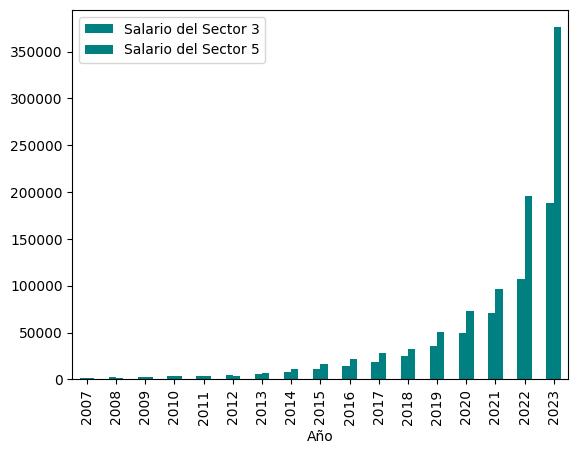

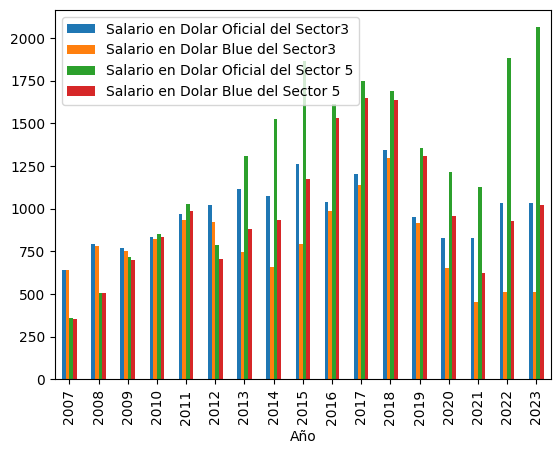

,Sector,Salario del Sector 3,Salario en Dolar Oficial del Sector3,Salario en Dolar Blue del Sector3,Salario del Sector 5,Salario en Dolar Oficial del Sector 5,Salario en Dolar Blue del Sector 5
Año,,,,,,,
2007,3.0,1986.083333,643.827771,639.685151,1106.000000,358.531539,356.224618
2008,3.0,2490.083333,791.770715,784.546804,1600.750000,508.989782,504.345890
2009,3.0,2660.583333,768.364373,754.094735,2477.500000,715.490739,702.203040
2010,3.0,3181.166667,836.616537,820.794938,3238.333333,851.650825,835.544907
2011,3.0,3850.333333,967.240403,931.639590,4080.250000,1024.997660,987.270999
2012,3.0,4417.666667,1022.870556,919.617367,3393.500000,785.734075,706.418517
2013,3.0,5511.333333,1113.816504,749.161758,6465.000000,1306.548391,878.794744
2014,3.0,7561.666667,1074.808725,656.368778,10750.944444,1528.129895,933.204884
2015,3.0,10845.833333,1261.469015,793.321142,16043.416667,1865.995208,1173.499652



Usted ha salido del programa.


In [1752]:
menu = Menu()
menu.mostrar_menu()